# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# data analysis

## format a (vectorizing)

In [3]:
avg_region_temp = pd.read_csv('nrmavg.txt', header=None, skiprows=1, sep=',')
avg_region_temp.columns = ['NORMALS', '1981-2010', 'YRS', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
                           'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANN']

avg_region_temp

,NORMALS,1981-2010,YRS,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
0,13876,BIRMINGHAM AP,AL 30,43.8,47.7,55.2,62.5,70.6,77.7,81.1,80.7,74.7,64.1,54.4,46.1,63.2
1,3856,HUNTSVILLE,AL 30,41.5,45.7,53.5,61.8,70.3,77.7,80.6,80.1,73.7,62.8,52.7,43.9,62.0
2,13838,MOBILE,AL 30,50.2,53.5,59.8,66.4,73.8,79.8,82.1,82.1,78.5,69.2,60.0,52.6,67.3
3,13895,MONTGOMERY,AL 30,46.6,50.5,57.5,64.1,72.4,79.0,81.8,81.5,76.3,65.9,56.5,48.5,65.1
4,26451,ANCHORAGE,AK 30,17.1,20.2,26.6,36.8,47.8,55.2,58.8,56.7,48.6,34.8,22.2,19.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,40504,POHNPEI-CAROLINE IS.,PC 30,80.7,80.9,81.1,81.1,81.2,81.0,80.8,81.0,80.8,80.8,80.9,80.7,80.9
278,40505,CHUUK E. CAROLINE IS.,PC 30,81.2,81.3,81.6,81.8,82.1,81.8,81.5,81.3,81.5,81.5,81.8,81.6,81.6
279,41606,WAKE ISLAND,PC 30,78.7,78.1,78.6,79.7,81.2,82.9,83.4,83.6,83.7,82.9,81.4,79.9,81.2
280,40308,YAP-W CAROLINE IS.,PC 30,82.2,82.2,82.6,83.4,83.7,83.0,82.5,82.4,82.6,82.8,82.9,82.6,82.7


In [4]:
avg_region_temp['STATE'] = avg_region_temp['YRS'].str.extract(r'([A-Za-z]{2})')
avg_region_temp['STATE'] = avg_region_temp['STATE'].fillna('n/a')


red_avg_region_temp = avg_region_temp[['1981-2010', 'STATE', 'ANN']]
red_avg_region_temp = red_avg_region_temp.rename(columns={'1981-2010': 'CITY'})
red_avg_region_temp

,CITY,STATE,ANN
0,BIRMINGHAM AP,AL,63.2
1,HUNTSVILLE,AL,62.0
2,MOBILE,AL,67.3
3,MONTGOMERY,AL,65.1
4,ANCHORAGE,AK,37.0
...,...,...,...
277,POHNPEI-CAROLINE IS.,PC,80.9
278,CHUUK E. CAROLINE IS.,PC,81.6
279,WAKE ISLAND,PC,81.2
280,YAP-W CAROLINE IS.,PC,82.7


In [5]:
X_a = red_avg_region_temp['STATE']
y_a = red_avg_region_temp['ANN']

## format b (numerically)

In [6]:
def geocode_with_rate_limit(location, max_retries=3, timeout=2):
    retries = 0
    while retries < max_retries:
        try:
            location_info = geolocator.geocode(location, timeout=timeout)
            return location_info
        except GeocoderTimedOut as e:
            print(f"Geocoding request for {location} timed out. Retrying... ({retries + 1}/{max_retries})")
            retries += 1
            #timeout *= 2  # Exponential backoff
            time.sleep(timeout)  # Introduce a delay between requests

    print(f"Max retries exceeded for {location}.")
    return None

In [7]:
geolocator = Nominatim(user_agent='kaspar_weather')

LATS = []
LONGS = []
location = []

for i, j in zip(red_avg_region_temp['CITY'], red_avg_region_temp['STATE']):
    location.append((i, j))

location_info = []
for x in location:
    try:
        y = geocode_with_rate_limit(x)
        location_info.append(y)
    except:
        location_info.append(None)

for i in location_info:
    try:
        LATS.append(i.latitude)
        LONGS.append(i.longitude)
    except:
        LATS.append(None)
        LONGS.append(None)

In [8]:
red_avg_region_temp['LATS'] = LATS
red_avg_region_temp['LONGS'] = LONGS

red_avg_region_temp

,CITY,STATE,ANN,LATS,LONGS
0,BIRMINGHAM AP,AL,63.2,33.520682,-86.802433
1,HUNTSVILLE,AL,62.0,34.729847,-86.585901
2,MOBILE,AL,67.3,30.691346,-88.043751
3,MONTGOMERY,AL,65.1,32.366966,-86.300648
4,ANCHORAGE,AK,37.0,61.216313,-149.894852
...,...,...,...,...,...
277,POHNPEI-CAROLINE IS.,PC,80.9,NaN,NaN
278,CHUUK E. CAROLINE IS.,PC,81.6,NaN,NaN
279,WAKE ISLAND,PC,81.2,27.425989,-82.672742
280,YAP-W CAROLINE IS.,PC,82.7,NaN,NaN


In [9]:
filtered_region_temp = red_avg_region_temp.dropna()
filtered_region_temp = filtered_region_temp.drop(['CITY', 'STATE'], axis = 1)
filtered_region_temp

,ANN,LATS,LONGS
0,63.2,33.520682,-86.802433
1,62.0,34.729847,-86.585901
2,67.3,30.691346,-88.043751
3,65.1,32.366966,-86.300648
4,37.0,61.216313,-149.894852
...,...,...,...
271,81.4,16.711316,121.890963
272,80.8,46.296303,-62.520560
273,81.8,7.343275,134.476677
279,81.2,27.425989,-82.672742


In [10]:
X_b = filtered_region_temp[['LATS', 'LONGS']]
y_b = filtered_region_temp['ANN']

# methods

## format a (vectorizing)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

In [12]:
# Generate random predictions
random_predictions = np.random.uniform(low=np.min(y_test), high=np.max(y_test), size=len(y_test))
mse_random = mean_squared_error(y_test, random_predictions)

print(f"Mean Squared Error (Random): {mse_random}")

Mean Squared Error (Random): 567.0890145100341


In [13]:
# Vectorizing strings, for numerical predictions
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [14]:
# Polynomial regression
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_vectorized, y_train)

y_pred_poly_test = model.predict(X_test_vectorized)
mse_poly_2_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 2, Testing): {mse_poly_2_test}')

y_pred_poly_val = model.predict(X_train_vectorized)
mse_poly_2_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 2, Validation): {mse_poly_2_val}')

Mean Squared Error (Polynomial Regression, degree = 2, Testing): 36.75757651699762
Mean Squared Error (Polynomial Regression, degree = 2, Validation): 13.780497411557217


In [15]:
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_vectorized, y_train)

y_pred_poly_test = model.predict(X_test_vectorized)
mse_poly_3_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 3, Testing): {mse_poly_3_test}')

y_pred_poly_val = model.predict(X_train_vectorized)
mse_poly_3_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 3, Validation): {mse_poly_3_val}')

Mean Squared Error (Polynomial Regression, degree = 3, Testing): 36.75757643395615
Mean Squared Error (Polynomial Regression, degree = 3, Validation): 13.780497411557223


In [16]:
degree = 4
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_vectorized, y_train)

y_pred_poly_test = model.predict(X_test_vectorized)
mse_poly_4_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 4, Testing): {mse_poly_4_test}')

y_pred_poly_val = model.predict(X_train_vectorized)
mse_poly_4_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 4, Validation): {mse_poly_4_val}')

Mean Squared Error (Polynomial Regression, degree = 4, Testing): 36.75757652873237
Mean Squared Error (Polynomial Regression, degree = 4, Validation): 13.780497411557217


In [17]:
# Decision tree
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train_vectorized, y_train)

y_pred_test = decision_tree.predict(X_test_vectorized)
mse_tree_test = mean_squared_error(y_test, y_pred_test)
print(f'Mean Squared Error: {mse_tree_test}')

y_pred_val = decision_tree.predict(X_train_vectorized)
mse_tree_val = mean_squared_error(y_train, y_pred_val)
print(f'Mean Squared Error (Decision Tree, Validation): {mse_tree_val}')

Mean Squared Error: 36.757576608952824
Mean Squared Error (Decision Tree, Validation): 13.780497411557217


In [18]:
# CNN (flattened)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_a)

X_train, X_test, y_train, y_test = train_test_split(X_a, y_encoded, test_size=0.2, random_state=42)

uniq_words = []
for i in X_a:
    if i not in uniq_words:
        uniq_words.append(i)
max_words = round(1.2 * len(uniq_words))
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

In [19]:
embedding_dim = 5000
epoch_num = 20

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

batch_size = 32
history = model.fit(
    X_train_padded, y_train,
    epochs=epoch_num, batch_size=batch_size,
    validation_split=0.2  # 20% of the training data will be used for validation
)

# Predictions on the testing set
cnn_predictions = model.predict(X_test_padded)
mse_cnn_test = mean_squared_error(y_test, cnn_predictions)

# Print the Mean Squared Error
print(f'Mean Squared Error (CNN, Testing): {mse_cnn_test}')

# Predictions on the training set
cnn_predictions = model.predict(X_train_padded)
mse_cnn_train = mean_squared_error(y_train, cnn_predictions)

# Print the Mean Squared Error
print(f'Mean Squared Error (CNN, Training): {mse_cnn_train}')

Epoch 1/20
6/6 [==============================] - 1s 40ms/step - loss: 11509.1895 - mae: 93.0716 - val_loss: 10341.1006 - val_mae: 86.5342
Epoch 2/20
6/6 [==============================] - 0s 14ms/step - loss: 10527.7295 - mae: 87.9280 - val_loss: 9211.2354 - val_mae: 80.2019
Epoch 3/20
6/6 [==============================] - 0s 10ms/step - loss: 9155.0654 - mae: 80.4320 - val_loss: 7645.1001 - val_mae: 71.4946
Epoch 4/20
6/6 [==============================] - 0s 9ms/step - loss: 7314.2603 - mae: 69.6435 - val_loss: 5740.2637 - val_mae: 60.1903
Epoch 5/20
6/6 [==============================] - 0s 10ms/step - loss: 5204.1533 - mae: 57.2964 - val_loss: 3828.4241 - val_mae: 46.9295
Epoch 6/20
6/6 [==============================] - 0s 10ms/step - loss: 3335.7542 - mae: 46.0374 - val_loss: 2459.4834 - val_mae: 38.7553
Epoch 7/20
6/6 [==============================] - 0s 10ms/step - loss: 2175.1597 - mae: 39.3356 - val_loss: 1984.2709 - val_mae: 38.3267
Epoch 8/20
6/6 [=======================

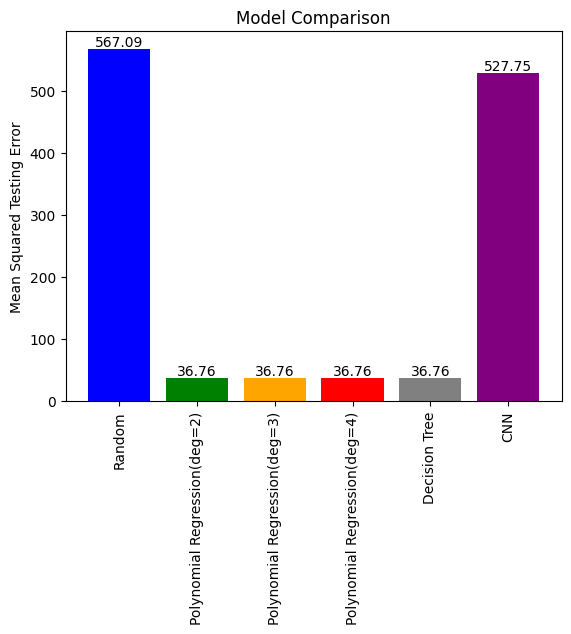

In [20]:
models = ['Random', 'Polynomial Regression(deg=2)', 'Polynomial Regression(deg=3)',
          'Polynomial Regression(deg=4)', 'Decision Tree', 'CNN']
mse_test_values = [mse_random, mse_poly_2_test, mse_poly_3_test, mse_poly_4_test, mse_tree_test, mse_cnn_test]

fig, ax = plt.subplots()
bars = ax.bar(models, mse_test_values, color=['blue', 'green', 'orange', 'red', 'gray', 'purple'])
for bar, value in zip(bars, mse_test_values):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(value, 2), ha='center', va='bottom')

plt.ylabel('Mean Squared Testing Error')
plt.xticks(rotation = 90)
plt.title('Model Comparison')
plt.show()

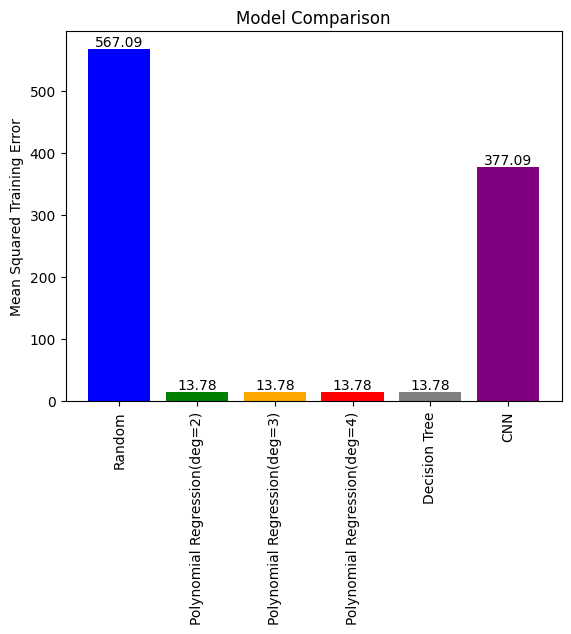

In [21]:
mse_val_values = [mse_random, mse_poly_2_val, mse_poly_3_val, mse_poly_4_val, mse_tree_val, mse_cnn_train]

fig, ax = plt.subplots()
bars = ax.bar(models, mse_val_values, color=['blue', 'green', 'orange', 'red', 'gray', 'purple'])
for bar, value in zip(bars, mse_val_values):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(value, 2), ha='center', va='bottom')

plt.ylabel('Mean Squared Training Error')
plt.xticks(rotation = 90)
plt.title('Model Comparison')
plt.show()

## format b (numerically)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

In [23]:
random_predictions = np.random.uniform(low=np.min(y_test), high=np.max(y_test), size=len(y_test))
mse_random = mean_squared_error(y_test, random_predictions)

print(f"Mean Squared Error (Random): {mse_random}")

Mean Squared Error (Random): 691.3466515772686


In [24]:
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred_poly_test = model.predict(X_test)
mse_poly_2_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 2, Testing): {mse_poly_2_test}')

y_pred_poly_val = model.predict(X_train)
mse_poly_2_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 2, Validation): {mse_poly_2_val}')

Mean Squared Error (Polynomial Regression, degree = 2, Testing): 24.886744816862574
Mean Squared Error (Polynomial Regression, degree = 2, Validation): 27.194357832387837


In [25]:
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred_poly_test = model.predict(X_test)
mse_poly_3_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 3, Testing): {mse_poly_3_test}')

y_pred_poly_val = model.predict(X_train)
mse_poly_3_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 3, Validation): {mse_poly_3_val}')

Mean Squared Error (Polynomial Regression, degree = 3, Testing): 31.036506563182662
Mean Squared Error (Polynomial Regression, degree = 3, Validation): 21.020988521395417


In [26]:
#This one runs so much faster than the above, vectorized version it made my heart stop for a moment

degree = 4
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred_poly_test = model.predict(X_test)
mse_poly_4_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 4, Testing): {mse_poly_4_test}')

y_pred_poly_val = model.predict(X_train)
mse_poly_4_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 4, Validation): {mse_poly_4_val}')

Mean Squared Error (Polynomial Regression, degree = 4, Testing): 17.65666445592678
Mean Squared Error (Polynomial Regression, degree = 4, Validation): 15.58387729796384


In [27]:
#You  couldn't even dream of doing a 5 degree polynomial for the vectorized data, but here it runs
# so quickly and smoothly it's as though it's nothing at all

degree = 5
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred_poly_test = model.predict(X_test)
mse_poly_5_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 5, Testing): {mse_poly_5_test}')

y_pred_poly_val = model.predict(X_train)
mse_poly_5_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 5, Validation): {mse_poly_5_val}')

Mean Squared Error (Polynomial Regression, degree = 5, Testing): 14.88572571299021
Mean Squared Error (Polynomial Regression, degree = 5, Validation): 12.995777861319766


In [28]:
degree = 6
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred_poly_test = model.predict(X_test)
mse_poly_6_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 6, Testing): {mse_poly_6_test}')

y_pred_poly_val = model.predict(X_train)
mse_poly_6_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 6, Validation): {mse_poly_6_val}')

Mean Squared Error (Polynomial Regression, degree = 6, Testing): 63.185948156975265
Mean Squared Error (Polynomial Regression, degree = 6, Validation): 10.51189106384891


In [29]:
degree = 16
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

y_pred_poly_test = model.predict(X_test)
mse_poly_16_test = mean_squared_error(y_test, y_pred_poly_test)
print(f'Mean Squared Error (Polynomial Regression, degree = 16, Testing): {mse_poly_16_test}')

y_pred_poly_val = model.predict(X_train)
mse_poly_16_val = mean_squared_error(y_train, y_pred_poly_val)
print(f'Mean Squared Error (Polynomial Regression, degree = 16, Validation): {mse_poly_16_val}')

Mean Squared Error (Polynomial Regression, degree = 16, Testing): 12298646.028381014
Mean Squared Error (Polynomial Regression, degree = 16, Validation): 8.149649527533867


In [30]:
# Decision tree
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

y_pred_test = decision_tree.predict(X_test)
mse_tree_test = mean_squared_error(y_test, y_pred_test)
print(f'Mean Squared Testing Error: {mse_tree_test}')

y_pred_val = decision_tree.predict(X_train)
mse_tree_val = mean_squared_error(y_train, y_pred_val)
print(f'Mean Squared Training Error: {mse_tree_val}')
#print(y_pred_poly_val)

Mean Squared Testing Error: 17.398301886792456
Mean Squared Training Error: 0.0025000000000000243


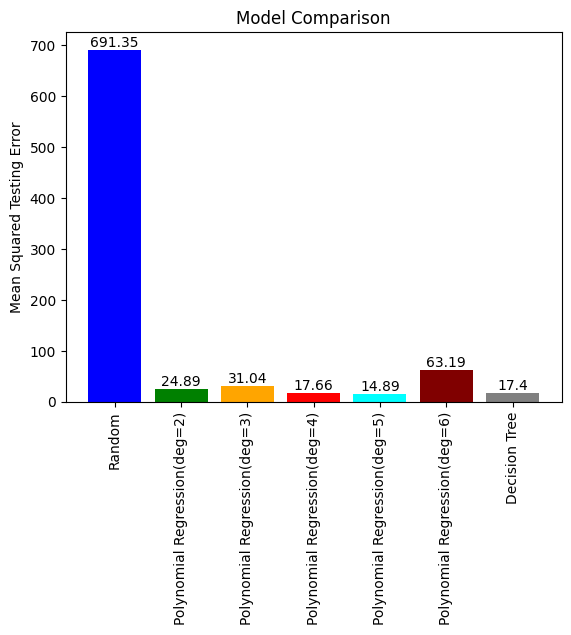

In [31]:
models = ['Random', 'Polynomial Regression(deg=2)', 'Polynomial Regression(deg=3)',
          'Polynomial Regression(deg=4)', 'Polynomial Regression(deg=5)',
          'Polynomial Regression(deg=6)', 'Decision Tree']
mse_test_values = [mse_random, mse_poly_2_test, mse_poly_3_test, mse_poly_4_test, mse_poly_5_test,
                   mse_poly_6_test, mse_tree_test]

fig, ax = plt.subplots()
bars = ax.bar(models, mse_test_values, color=['blue', 'green', 'orange', 'red', 'cyan', 'maroon', 'gray'])
for bar, value in zip(bars, mse_test_values):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(value, 2), ha='center', va='bottom')

plt.ylabel('Mean Squared Testing Error')
plt.xticks(rotation = 90)
plt.title('Model Comparison')
plt.show()

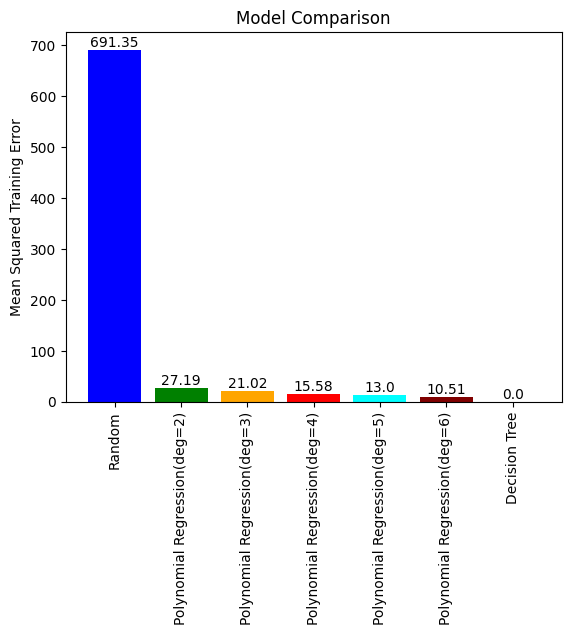

In [32]:
models = ['Random', 'Polynomial Regression(deg=2)', 'Polynomial Regression(deg=3)',
          'Polynomial Regression(deg=4)', 'Polynomial Regression(deg=5)',
          'Polynomial Regression(deg=6)', 'Decision Tree']
mse_val_values = [mse_random, mse_poly_2_val, mse_poly_3_val, mse_poly_4_val, mse_poly_5_val,
                   mse_poly_6_val, mse_tree_val]

fig, ax = plt.subplots()
bars = ax.bar(models, mse_val_values, color=['blue', 'green', 'orange', 'red', 'cyan', 'maroon', 'gray'])
for bar, value in zip(bars, mse_val_values):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(value, 2), ha='center', va='bottom')

plt.ylabel('Mean Squared Training Error')
plt.xticks(rotation = 90)
plt.title('Model Comparison')
plt.show()